<a href="https://colab.research.google.com/github/tusharmakwana/QOSF-Mentorship-Program/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit

     |████████████████████████████████| 6.5 MB 25.6 MB/s 
     |████████████████████████████████| 18.0 MB 93 kB/s 
     |████████████████████████████████| 238 kB 68.6 MB/s 
     |████████████████████████████████| 200 kB 45.2 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 1.6 MB 44.6 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 42.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 3.6 MB 50.8 MB/s 
     |████████████████████████████████| 113 kB 47.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=ae4998d15813b25ac8430ac84999a8b1a8ad9f59f5bea96cd482140aca419b70
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c9

In [3]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

In [4]:
NUMBER_OF_BITS = 4
INDEX_OF_ALL_BITS = range(NUMBER_OF_BITS)
NUMBER_OF_ROUNDS = 2

def phaseOracle():
    phaseoracle = QuantumCircuit(NUMBER_OF_BITS)
    phaseoracle.x(1)
    phaseoracle.h(1)   
    phaseoracle.ccx(0,3,1)
    phaseoracle.ccx(2,3,1)
    phaseoracle.h(1)
    phaseoracle.x(1)
    oracle = phaseoracle.to_gate()
    oracle.name = "Oracle"
    
    return oracle

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s

In [5]:
# Construct the circuit    
grover_circuit = QuantumCircuit(NUMBER_OF_BITS)

for i in INDEX_OF_ALL_BITS:
    grover_circuit.h(i)

theOracle = phaseOracle()
theDiffuser = diffuser(NUMBER_OF_BITS)
for _ in range(NUMBER_OF_ROUNDS):
    grover_circuit.append(theOracle, INDEX_OF_ALL_BITS)
    grover_circuit.append(theDiffuser, INDEX_OF_ALL_BITS)

grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐ ░ ┌─┐         
   q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├─░─┤M├─────────
        ├───┤│         ││           ││         ││           │ ░ └╥┘┌─┐      
   q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├─░──╫─┤M├──────
        ├───┤│  Oracle ││  Diffuser ││  Oracle ││  Diffuser │ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├─░──╫──╫─┤M├───
        ├───┤│         ││           ││         ││           │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├─░──╫──╫──╫─┤M├
        └───┘└─────────┘└───────────┘└─────────┘└───────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                 0  1  2  3

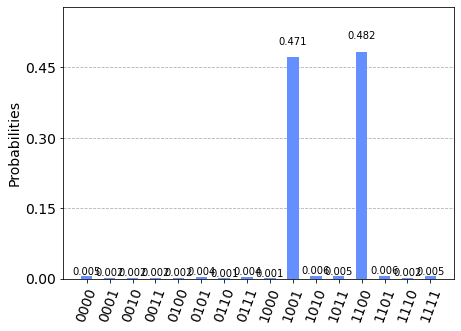

In [6]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_circuit, backend=simulator, shots=1000).result().get_counts(grover_circuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)